In [1]:
%%html
<style>
#notebook-container {width: 100%; background-color: #EEE}
.code_cell {flex-direction: row !important;}
.code_cell .output_wrapper {width: 50%;background-color: #FFF}
.code_cell .input {width: 50%;background-color: #FFF}
</style>

In [2]:
%matplotlib inline

import numpy as np
from models import B2B, Forward, Backward, GridCCA, GridPLS, GridRegCCA
from models import score_knockout
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import scale

import matplotlib.pyplot as plt
from tqdm import trange
import pickle
import time
import submitit
import seaborn as sns
import pandas as pd
from tqdm import trange
from itertools import product
from tqdm import tqdm

/private/home/jeanremi/.conda/envs/mous/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/private/home/jeanremi/.conda/envs/mous/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
class Synthetic(object):
    def __init__(self,
                 dim_x=50,         # number of features
                 dim_y=30,         # number of sensors
                 nc=5,             # number of selected features
                 snr=1.0,          # signal-to-noise ratio
                 nonlinear=False):  # number of selected features

        # linear transformation
        self.F = np.random.randn(dim_x, dim_y) / np.sqrt(dim_x)

        # masking transformation
        self.E = np.array([0] * (dim_x - nc) + [1] * (nc))

        # features covariance
        self.cov_X = np.random.randn(dim_x, dim_x) / np.sqrt(dim_x)
        self.cov_X = self.cov_X @ self.cov_X.T

        # noise covariance
        self.cov_N = np.random.randn(dim_x, dim_x) / np.sqrt(dim_x)
        self.cov_N = self.cov_N @ self.cov_N.T

        self.dim_x = dim_x
        self.dim_y = dim_y
        self.nonlinear = nonlinear
        self.snr = snr

    def sample(self, n_samples=1000):
        X = np.random.multivariate_normal(np.zeros(self.dim_x),
                                          self.cov_X, n_samples)
        N = np.random.multivariate_normal(np.zeros(self.dim_x),
                                          self.cov_N, n_samples)

        # observed sensor data
        Y = (self.snr * X @ np.diag(self.E) + N) @ self.F

        if self.nonlinear:
            Y = 1. / (1. + np.exp(-Y))

        # return inputs, outputs, and solution
        return scale(X), scale(Y)


def run(args=dict()):
    import warnings
    warnings.filterwarnings("ignore")

    models = {
        "Forward": Forward(),
        "Backward": Backward(),
        "PLS": GridPLS(),
        "CCA": GridCCA(),
        "RegCCA": GridRegCCA(),
        "B2B": B2B(),
    }

    n_samples = args.get('n_samples', 1000)
    dim_x = args.get('dim_x', 100)
    dim_y = args.get('dim_y', 100)
    snr = args.get('snr', 1)
    nc = args.get('nc', 5)
    nonlinear = args.get('nonlinear', 0)
    n_seeds = args.get('n_seeds', 10)
    refit_ko = args.get('refit_ko', False)

    results = []

    for seed in range(n_seeds):
        np.random.seed(seed)

        # Make environment
        synthetic = Synthetic(dim_x, dim_y, nc,
                              snr, nonlinear)

        # Make data
        X_train, Y_train = synthetic.sample(n_samples)
        X_test, Y_test = synthetic.sample(n_samples * 10)

        for m, model in models.items():

            # fit model on training data
            start = time.time()
            model.fit(X_train, Y_train)
            duration = time.time() - start

            # Estimate effect from model parameters
            auc = roc_auc_score(synthetic.E, model.E_)

            # Estimate effect from prediction reliability on held-out data
            XY_train = None if not refit_ko else (X_train, Y_train)
            r_delta = score_knockout(model, X_test, Y_test, XY_train)

            r_in = r_delta[synthetic.E == 1].mean()
            r_out = r_delta[synthetic.E == 0].mean()

            # Store results
            id = '_'.join(map(str, [dim_x, dim_y, nc, snr,
                                    nonlinear, m, seed]))
            result = dict(dim_x=dim_x, dim_y=dim_y, nc=nc, snr=snr,
                          nonlinear=nonlinear, model=m, seed=seed,
                          r_in=r_in, r_out=r_out, auc=auc, duration=duration,
                          id=id)
            print(result)
            results.append(result)
    return results

In [4]:
from common import data_path
folder = data_path + '/../jrr_iclr'

/private/home/jeanremi/.conda/envs/mous/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [5]:
executor = submitit.AutoExecutor(folder=folder)

In [6]:
executor.update_parameters(timeout_min=720, 
                           partition='learnfair,uninterrupted,scavenge',
                           #partition='priority',
                           comment='iclr',
                           constraint='pascal', cpus_per_task=10)

In [7]:
jobs = list()

snrs = np.logspace(-3, 1, 10)
dim_xs = np.logspace(1, 2, 10).astype(int)  # FIXME go to 1e3
dim_ys = np.logspace(1, 2, 6).astype(int)
ncs = np.logspace(0.5, 1.8, 10).astype(int)

all_args = list()
for snr, dim_x, dim_y, nc in product(snrs, dim_xs, dim_ys, ncs):
    if nc>=dim_x: continue
    args = dict(snr=snr, n_seeds=5,
                dim_x=dim_x, dim_y=dim_y, nc=nc)
    all_args.append([args,])

jobs = executor.map_array(run, *zip(*all_args))

In [13]:
str(j.paths.result_pickle)

'/private/home/jeanremi/data/mous/raw/../jrr_iclr/20030036_152_0_result.pkl'

In [8]:
all_results = list()
for i, j in tqdm(enumerate(jobs)):
    if not j.done():
        continue
    if j.state == 'COMPLETED':
        all_results.extend(j.result())
df = pd.DataFrame(all_results)
#df.to_pickle('results_dataframe_newgrid.pkl')

152it [15:14,  6.00s/it]

KeyboardInterrupt: 

In [16]:
pickle.load?

In [141]:
all_results = list()
for j in tqdm(jobs):
    fname = str(j.paths.result_pickle)
    with open(fname, 'rb') as f:
        state, result = pickle.load(f)
        if state != 'success':
            continue
        all_results.extend(result)
df = pd.DataFrame(all_results)


100%|██████████| 4380/4380 [00:02<00:00, 1705.91it/s]

In [143]:
df.r_in.min()

-0.4531943601242701

In [144]:
df.to_pickle('results_dataframe_newgrid.pkl')

In [145]:
df = df.query('model != "CCA"')

In [146]:
df['id_noseed'] = df['id'].apply(lambda s: '_'.join(s.split('_')[:5]))

In [147]:
df = df.drop(columns=['id', 'nonlinear'])

In [148]:
df = df.groupby(['id_noseed', 'model']).mean()

In [149]:
assert(len(df['seed'].unique())==1)
df = df.drop(columns=['seed'])

In [150]:
for _, idx in df.groupby(['id_noseed']):
    df.loc[idx.index, 'r_in_b2b'] = idx.query("model=='B2B'").r_in.values[0]
    df.loc[idx.index, 'r_out_b2b'] = idx.query("model=='B2B'").r_out.values[0]
    df.loc[idx.index, 'auc_b2b'] = idx.query("model=='B2B'").auc.values[0]

In [156]:
idx.query("model=='B2B'").auc

id_noseed                    model
77_63_8_3.593813663804626_0  B2B      1.0
Name: auc, dtype: float64

In [151]:
df['delta_r_in'] = df['r_in'] - df['r_in_b2b']
df['delta_r_out'] = df['r_out'] - df['r_out_b2b']
df['delta_auc'] = df['auc'] - df['auc_b2b']

In [152]:
df.r_in.min()

-0.0022327977123242867

In [154]:
df = df.reset_index()

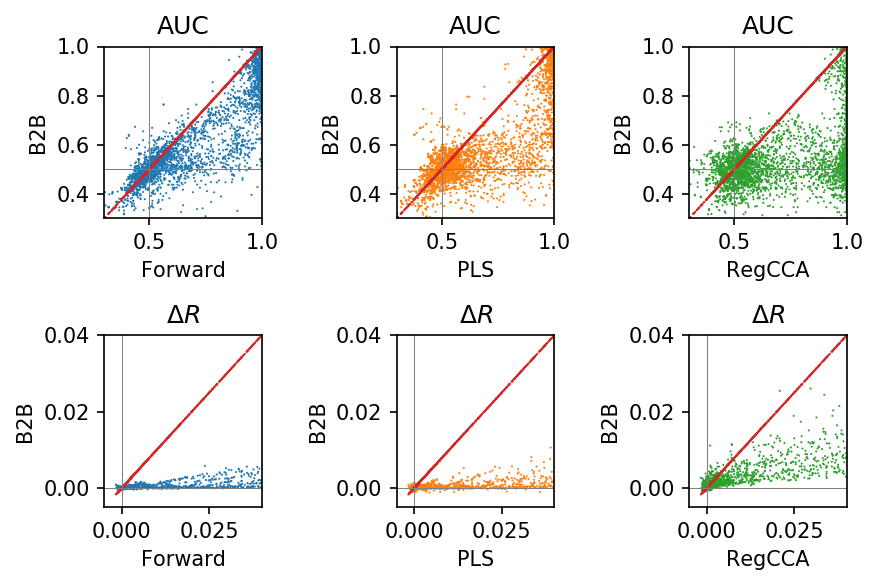

In [179]:
fig = plt.figure(figsize=(6,4), dpi=150)


ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2, sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(2, 3, 3, sharex=ax1, sharey=ax1)

for ax, model in zip((ax1, ax2, ax3), ('Forward', 'PLS', 'RegCCA', 'B2B')):
    sns.scatterplot(y='auc', x='auc_b2b', s=1, hue='model', linewidth=0,
                data=df.query('model==@model'), ax=ax,
                hue_order=['Forward', 'PLS', 'RegCCA', 'B2B'], legend=False)
    
    sns.scatterplot(y='auc', x='auc_b2b', s=1, hue='model', linewidth=0,
                data=df.query('model=="B2B"'), ax=ax,
                hue_order=['Forward', 'PLS', 'RegCCA', 'B2B'], legend=False)
    ax.axhline(.5, color='gray', lw=.5)
    ax.axvline(.5, color='gray', lw=.5)
    ax.set_xlim(.3, 1.)
    ax.set_ylim(.3, 1.)
    ax.set_title('AUC')
    ax.set_xlabel(model)
    ax.set_ylabel(r'B2B')

ax4 = fig.add_subplot(2, 3, 4)
ax5 = fig.add_subplot(2, 3, 5, sharex=ax4, sharey=ax4)
ax6 = fig.add_subplot(2, 3, 6, sharex=ax4, sharey=ax4)
for ax, model in zip((ax4, ax5, ax6), ('Forward', 'PLS', 'RegCCA', 'B2B')):
    sns.scatterplot(y='r_in', x='r_in_b2b', s=1, hue='model', linewidth=0,
                data=df.query('model==@model'), ax=ax,
                hue_order=['Forward', 'PLS', 'RegCCA', 'B2B'], legend=False)
    
    sns.scatterplot(y='r_in', x='r_in_b2b', s=1, hue='model', linewidth=0,
                data=df.query('model=="B2B"'), ax=ax,
                hue_order=['Forward', 'PLS', 'RegCCA', 'B2B'], legend=False)
    ax.axhline(0, color='gray', lw=.5)
    ax.axvline(0, color='gray', lw=.5)
    ax.set_xlim(-.005, .04)
    ax.set_ylim(-.005, .04)
    ax.set_title(r'$\Delta R$')
    ax.set_xlabel(model)
    ax.set_ylabel(r'B2B')
fig.tight_layout()
plt.savefig('delta_auc.pdf')

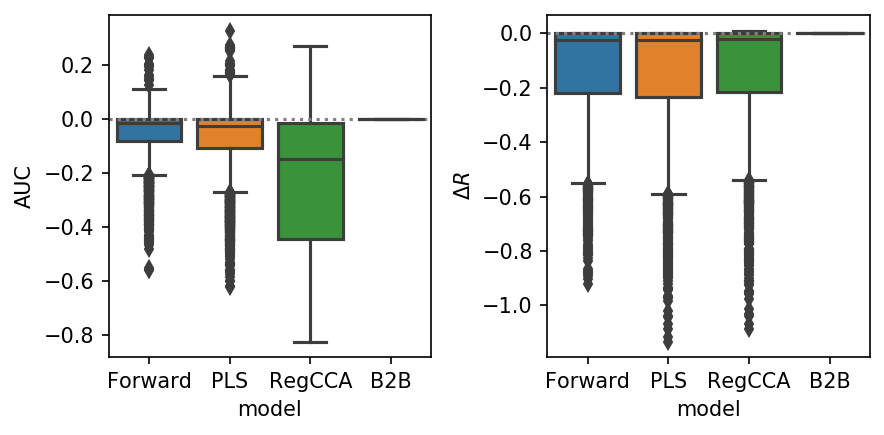

In [119]:
fig, axes = plt.subplots(1,2, figsize=(6,3), dpi=150)
sns.boxplot(y='delta_auc', x='model', #s=1,
            data=df.query('model!="Backward"'), ax=axes[0],
            order=['Forward', 'PLS', 'RegCCA', 'B2B'])
axes[0].set(ylabel=r'AUC')
axes[0].axhline(0, color='gray',ls=':')

sns.boxplot(y='delta_r_in', x='model', #s=1,
            data=df.query('model!="Backward"'), ax=axes[1],
            order=['Forward', 'PLS', 'RegCCA', 'B2B'])
axes[1].set(ylabel=r'$\Delta R$')
axes[1].axhline(0, color='gray',ls=':')

fig.tight_layout()
plt.savefig('delta_auc.pdf')

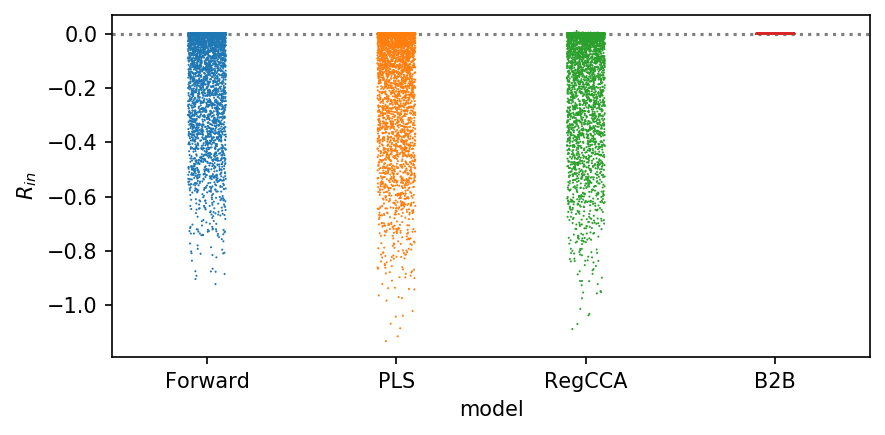

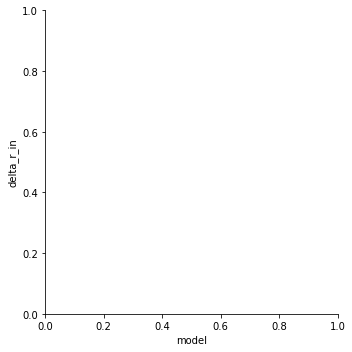

In [107]:
fig, axes = plt.subplots(1,1, figsize=(6,3), dpi=150)
sns.catplot(y='delta_r_in', x='model', s=1,
            data=df.query('model!="Backward"'), ax=axes,
            order=['Forward', 'PLS', 'RegCCA', 'B2B'])
axes.set(ylabel=r'$R_{in}$')
axes.axhline(0, color='gray',ls=':')
fig.tight_layout()
plt.savefig('delta_r_in.pdf')

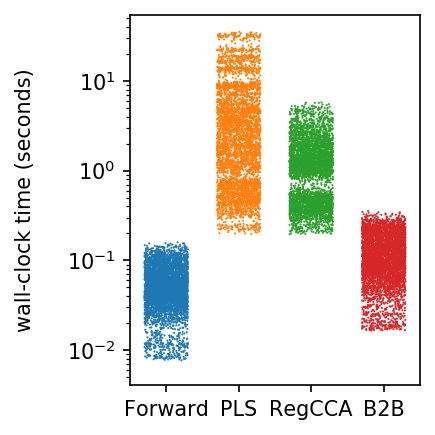

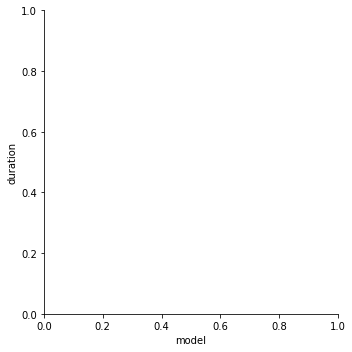

In [189]:
fig, axes = plt.subplots(1,1, figsize=(3,3), dpi=150)
sns.catplot(y='duration', x='model', s=1, jitter=.3,
            data=df.query('model!="Backward"'), ax=axes,
            order=['Forward', 'PLS', 'RegCCA', 'B2B'])
axes.set(yscale='log')
axes.set(ylabel='wall-clock time (seconds)\n')
axes.set_xlabel('')
fig.tight_layout()
fig.savefig('duration.pdf')

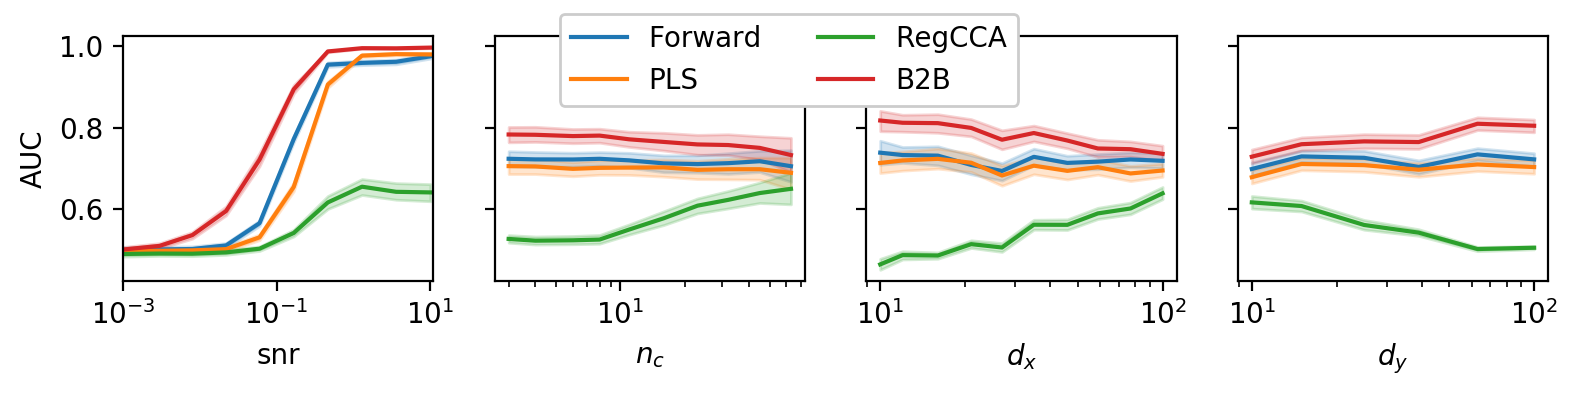

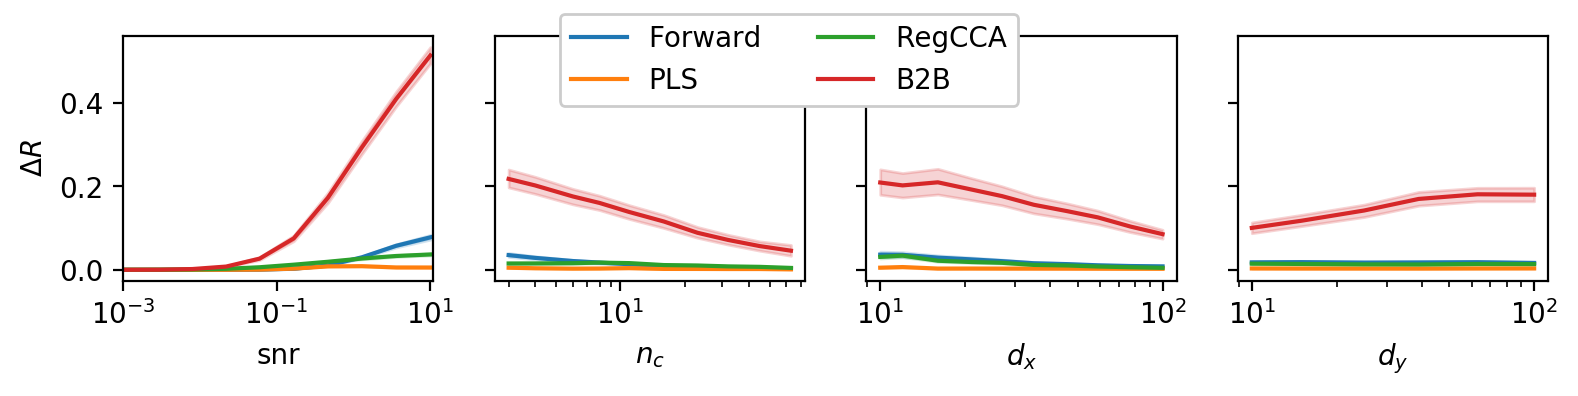

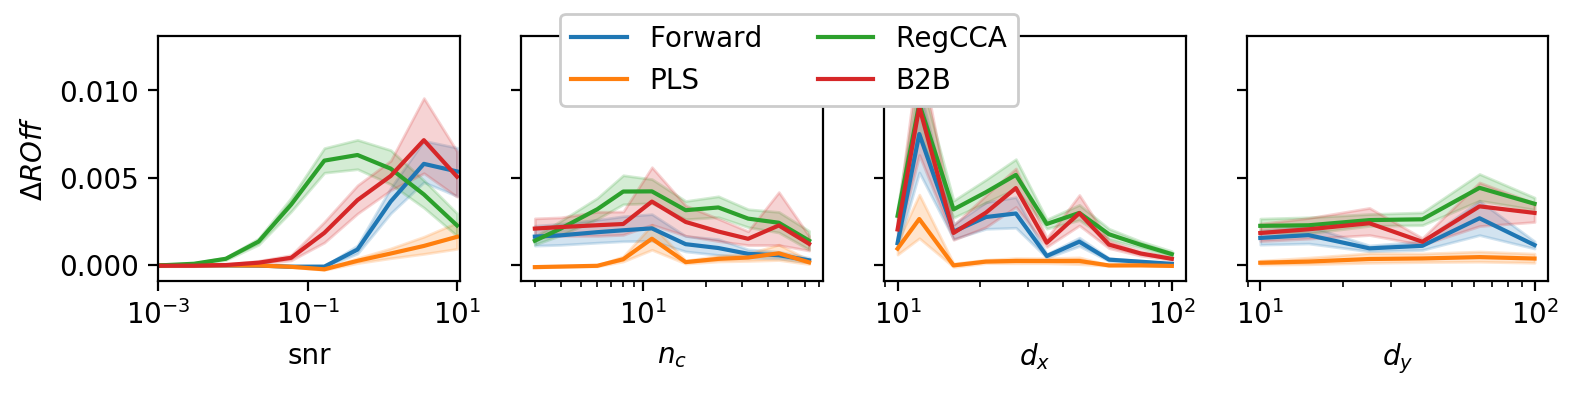

In [188]:
df['snr'] = df['snr'].round(3)

metrics = dict(auc='AUC', r_in=r'$\Delta R$', r_out=r'$\Delta R Off$')

for metric, metric_label in metrics.items():
    
    fig, axes = plt.subplots(1,4, figsize=(8,2), sharey=True, dpi=200)

    params = dict(snr='snr', nc=r'$n_c$', dim_x=r'$d_x$', dim_y=r'$d_y$')
    
    for ax, (param, label) in zip(axes, params.items()):

        sns.lineplot(y=metric, x=param, data=df, hue='model', ax=ax, 
                     hue_order=['Forward', 'PLS', 'RegCCA', 'B2B'])
        ax.set(xlabel=label)
        ax.set(xscale='log')
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()

    fig.legend(handles[1:], labels[1:], loc='upper center', ncol=2, framealpha=1)
    axes[0].set(ylabel=metric_label)
    axes[0].set(xlim=(1e-3, 11))

    fig.tight_layout()
    plt.savefig(metric + '_condition.pdf')

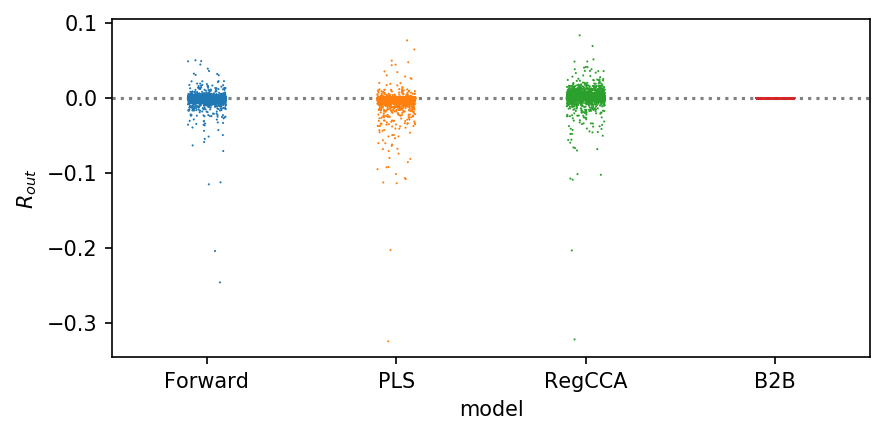

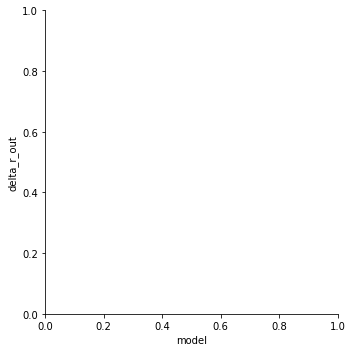

In [106]:
fig, axes = plt.subplots(1,1, figsize=(6,3), dpi=150)
sns.catplot(y='delta_r_out', x='model', s=1,
            data=df.query('model!="Backward"'), ax=axes,
            order=['Forward', 'PLS', 'RegCCA', 'B2B'])
axes.set(ylabel=r'$R_{out}$')
axes.axhline(0, color='gray',ls=':')
fig.tight_layout()
plt.savefig('delta_r_out.pdf')